Hyperparameter varied - depth of QCNN by varying the number of Quantum layers

Necessary imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2022-07-28 20:55:09.527511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 20:55:09.527538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setting the hyperparameters of the model

In [122]:
n_epochs=10
n_layers=9
n_train = 250    # Size of the train dataset
n_test = 50     # Size of the test dataset

In [123]:
SAVE_PATH="/home/user/Desktop/impl/"
PREPROCESS=True
np.random.seed(0)
tf.random.set_seed(0)

loading the data

In [124]:
mnist_dataset=keras.datasets.mnist
(train_images,train_labels),(test_images,test_labels)=mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

test_images.shape

(50, 28, 28)

normalising the data

In [125]:
train_images=train_images/255
test_images=test_images/255
train_images.shape

(250, 28, 28)

adding extra dimension for convolution channels

In [126]:
train_images=np.array(train_images[...,tf.newaxis],requires_grad=False)
test_images=np.array(test_images[...,tf.newaxis],requires_grad=False)#requires_grad??
train_images.shape

(250, 28, 28, 1)

initilaizing a default.qubit device simulating a system of 4 qubits

In [127]:
dev = qml.device("default.qubit", wires=4)

Initialising random parameters

In [128]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))#1 x 4 returned as tensor
rand_params

tensor([[3.44829694, 4.49366732, 3.78727399, 3.42360201],
        [2.66190161, 4.0582724 , 2.74944154, 5.60317502],
        [6.0548717 , 2.40923412, 4.97455513, 3.32314479],
        [3.56912924, 5.8156952 , 0.44633272, 0.54744954],
        [0.12703594, 5.23150478, 4.88930306, 5.46644755],
        [6.14884039, 5.02126135, 2.89956035, 4.90420945],
        [0.74314013, 4.02074236, 0.90071527, 5.93552986],
        [3.27886971, 2.60539781, 1.66225193, 4.86465374],
        [2.86607707, 3.57157584, 0.1180598 , 3.88071828]], requires_grad=True)

qnode consists of a quantum function and a device on which it executes

In [129]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)#an embedding layer of local Ry rotations

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))#a random circuit of n_layers rand_params is the weight first argument of weight is the number of layers and the second argument of weights is the number of rotations

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]#measurement in the computational basis

drawing the circuit for illustration purposes with random parameters

In [130]:
drawer = qml.draw(circuit)
print(drawer([1,2,3,4]))

0: ──RY(3.14)──╭RandomLayers(M0)─┤  <Z>
1: ──RY(6.28)──├RandomLayers(M0)─┤  <Z>
2: ──RY(9.42)──├RandomLayers(M0)─┤  <Z>
3: ──RY(12.57)─╰RandomLayers(M0)─┤  <Z>


Convolution the input image with many applications of the same quantum circuit.

In [131]:
def quanv(image):
    out = np.zeros((14, 14, 4))#initilaising output image with 4 different channels

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):#the 4 expectation values are mapped into 4 different channels of a single output pixel
                out[j // 2, k // 2, c] = q_results[c]
    return out


preprocessing the train and test images as the quanvoluional layer isnt trained

In [132]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1,n_test ), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

    print(q_train_images.shape)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
250/250        
Quantum pre-processing of test images:
(250, 14, 14, 4)


In [133]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(14,14,4)))#convolution layer
    model.add(MaxPool2D(2,2))#pooling layer

    model.add(Flatten())#flattening to form 1 D array
    model.add(Dense(100,activation='relu'))# hidden layer
    model.add(Dense(10,activation='softmax'))#output layer

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    batch_size=16,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
16/16 - 1s - loss: 2.2469 - accuracy: 0.2080 - 557ms/epoch - 35ms/step
Epoch 2/10
16/16 - 0s - loss: 1.9830 - accuracy: 0.5320 - 109ms/epoch - 7ms/step
Epoch 3/10
16/16 - 0s - loss: 1.6564 - accuracy: 0.6040 - 101ms/epoch - 6ms/step
Epoch 4/10
16/16 - 0s - loss: 1.2880 - accuracy: 0.7960 - 99ms/epoch - 6ms/step
Epoch 5/10
16/16 - 0s - loss: 0.9577 - accuracy: 0.7800 - 94ms/epoch - 6ms/step
Epoch 6/10
16/16 - 0s - loss: 0.7435 - accuracy: 0.8560 - 102ms/epoch - 6ms/step
Epoch 7/10
16/16 - 0s - loss: 0.5935 - accuracy: 0.8760 - 105ms/epoch - 7ms/step
Epoch 8/10
16/16 - 0s - loss: 0.4553 - accuracy: 0.9120 - 88ms/epoch - 5ms/step
Epoch 9/10
16/16 - 0s - loss: 0.3730 - accuracy: 0.9080 - 103ms/epoch - 6ms/step
Epoch 10/10
16/16 - 0s - loss: 0.3069 - accuracy: 0.9240 - 99ms/epoch - 6ms/step


Evaluation of model

In [14]:
q_model.evaluate(q_test_images,test_labels) #1

2/2 [==============================] - 0s 5ms/step - loss: 0.3116 - accuracy: 0.9000


[0.31162673234939575, 0.8999999761581421]

In [27]:
q_model.evaluate(q_test_images,test_labels) #2

2/2 [==============================] - 0s 5ms/step - loss: 0.3295 - accuracy: 0.9000


[0.32947686314582825, 0.8999999761581421]

In [40]:
q_model.evaluate(q_test_images,test_labels) #3

2/2 [==============================] - 0s 4ms/step - loss: 0.4609 - accuracy: 0.8400


[0.4608822166919708, 0.8399999737739563]

In [53]:
q_model.evaluate(q_test_images,test_labels) #4

2/2 [==============================] - 0s 5ms/step - loss: 0.4370 - accuracy: 0.8800


[0.43700873851776123, 0.8799999952316284]

In [68]:
q_model.evaluate(q_test_images,test_labels) #5

2/2 [==============================] - 0s 9ms/step - loss: 0.4489 - accuracy: 0.8800


[0.4489450752735138, 0.8799999952316284]

In [81]:
q_model.evaluate(q_test_images,test_labels) #6

2/2 [==============================] - 0s 6ms/step - loss: 0.6472 - accuracy: 0.8000


[0.6471536159515381, 0.800000011920929]

In [107]:
q_model.evaluate(q_test_images,test_labels) #7

2/2 [==============================] - 0s 6ms/step - loss: 0.4363 - accuracy: 0.8800


[0.4363259971141815, 0.8799999952316284]

In [121]:
q_model.evaluate(q_test_images,test_labels) #8

2/2 [==============================] - 0s 6ms/step - loss: 0.6194 - accuracy: 0.8000


[0.6193544864654541, 0.800000011920929]

In [134]:
q_model.evaluate(q_test_images,test_labels) #9

2/2 [==============================] - 0s 7ms/step - loss: 0.7036 - accuracy: 0.8000


[0.7036087512969971, 0.800000011920929]

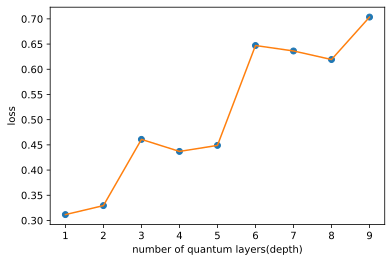

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x=np.array([1,2,3,4,5,6,7,8,9])
y=np.array([0.31162673234939575,0.32947686314582825,0.4608822166919708,0.43700873851776123,0.4489450752735138,0.6471536159515381,0.6363259971141815,0.6193544864654541,0.7036087512969971])

plt.plot(x,y,'o')
plt.plot(x,y)

plt.xlabel("number of quantum layers(depth)")
plt.ylabel("loss")

plt.show()

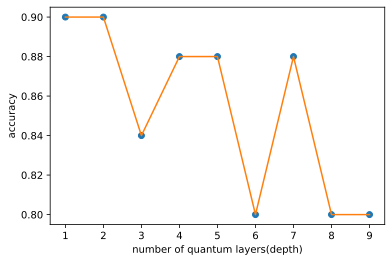

In [4]:
x=np.array([1,2,3,4,5,6,7,8,9])
y=np.array([0.8999999761581421,0.8999999761581421,0.8399999737739563,0.8799999952316284,0.8799999952316284,0.800000011920929,0.8799999952316284,0.800000011920929,0.800000011920929])

plt.plot(x,y,'o')
plt.plot(x,y)

plt.xlabel("number of quantum layers(depth)")
plt.ylabel("accuracy")

plt.show()